# **Comparing Models**

This notebook compares 6 pre-trained CNN models for multi-class brain tumor classification using ROC AUC scores

Models evaluated: EfficientNetB0 (Augmented), DenseNet121 (Augmented), MobileNetV2 (Augmented), ResNet50 (Baseline & Augmented), VGG19 (Baseline)

Key Results: 
- DenseNet121 (Aug) performed the best with an AUC of 0.99
- MobileNetV2 (Aug) and ResNet50 (Aug) followed closely with AUCs of 0.98 and 0.97 respectively
- VGG19 (Baseline) showed pretty solid performance with 0.92 AUC
- EfficientNetB0 (Aug) underperformed significantly (0.52 AUC)... but may need model tuning

---

In [1]:
# imports 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
# load in the validation data 
val_dir = 'tumor_data_cleaned/Testing'

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

# labels for roc computation
y_true = val_gen.classes
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

Found 1311 images belonging to 4 classes.


In [3]:
# the 3 models 
efficientnet_model = load_model("efficientnetb0_augmented_model.h5")
densenet_model = load_model("BrainTumor_DenseNet121.h5")
mobilenet_model = load_model("MobileNetV2_brain_tumor_model.h5")

In [4]:
# predict probabilities
y_pred_eff = efficientnet_model.predict(val_gen)
y_pred_dense = densenet_model.predict(val_gen)
y_pred_mobile = mobilenet_model.predict(val_gen)

C:\Users\eliga\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step


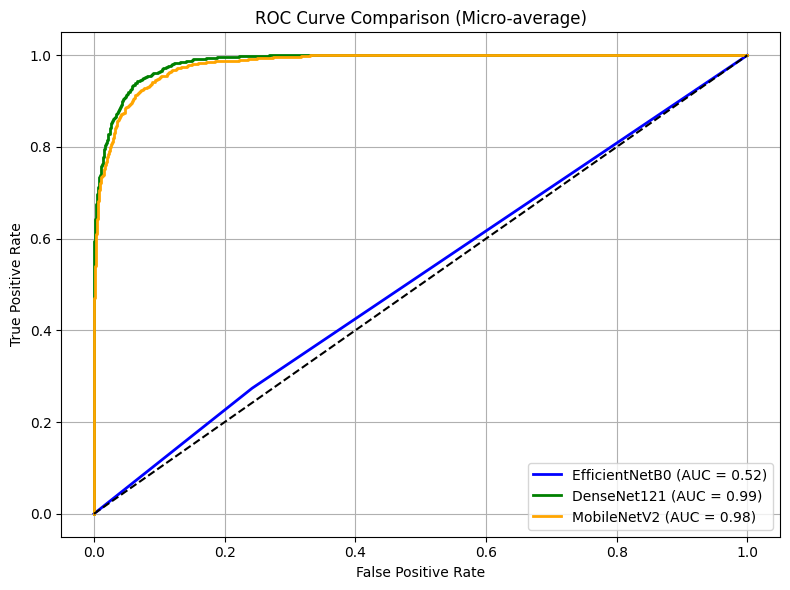

In [5]:
# roc curves
def plot_roc(y_true_bin, y_score, model_name, color):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(4):  # 4 classes
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # average roc
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})', color=color, linewidth=2)


plt.figure(figsize=(8, 6))
plot_roc(y_true_bin, y_pred_eff, "EfficientNetB0", "blue")
plot_roc(y_true_bin, y_pred_dense, "DenseNet121", "green")
plot_roc(y_true_bin, y_pred_mobile, "MobileNetV2", "orange")


plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison (Micro-average)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("compare3_roc_curve.png", dpi=300)
plt.show()

### **Evaluating all my other saved models**


Evaluating ResNet50 (Augmented)...
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 217ms/step

Evaluating ResNet50 (Baseline)...
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 212ms/step

Evaluating VGG19 (Baseline)...
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 494ms/step


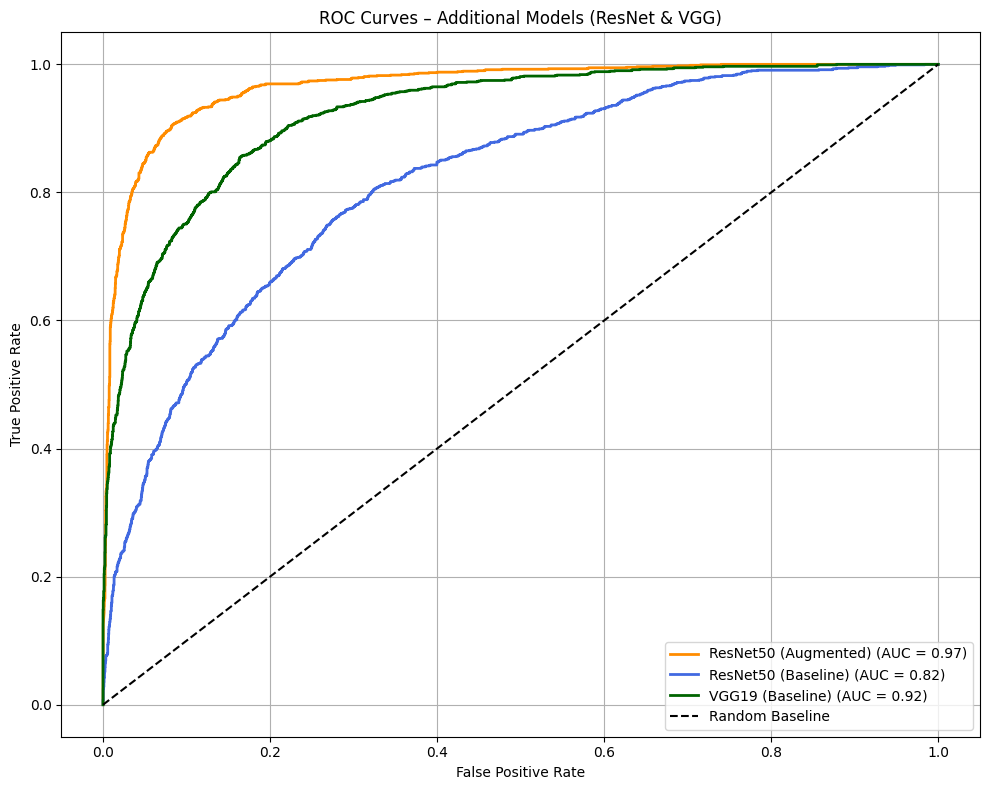

In [13]:
# remaining models
model_info = {
    "ResNet50 (Augmented)": ("resnet50_augmented_model.h5", 'darkorange'),
    "ResNet50 (Baseline)": ("BrainTumorBaseline_ResNet50.h5", 'royalblue'),
    "VGG19 (Baseline)": ("BrainTumorBaseline_VGG19.h5", 'darkgreen')
}

plt.figure(figsize=(10, 8))

for model_name, (path, color) in model_info.items():
    print(f"\nEvaluating {model_name}...")
    try:
        model = tf.keras.models.load_model(path, compile=False)
        y_pred = model.predict(val_gen, verbose=1)
        
        # roc curve
        plot_roc(y_true_bin, y_pred, model_name, color)
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Additional Models (ResNet & VGG)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_resnet_vgg_models.png", dpi=300)
plt.show()

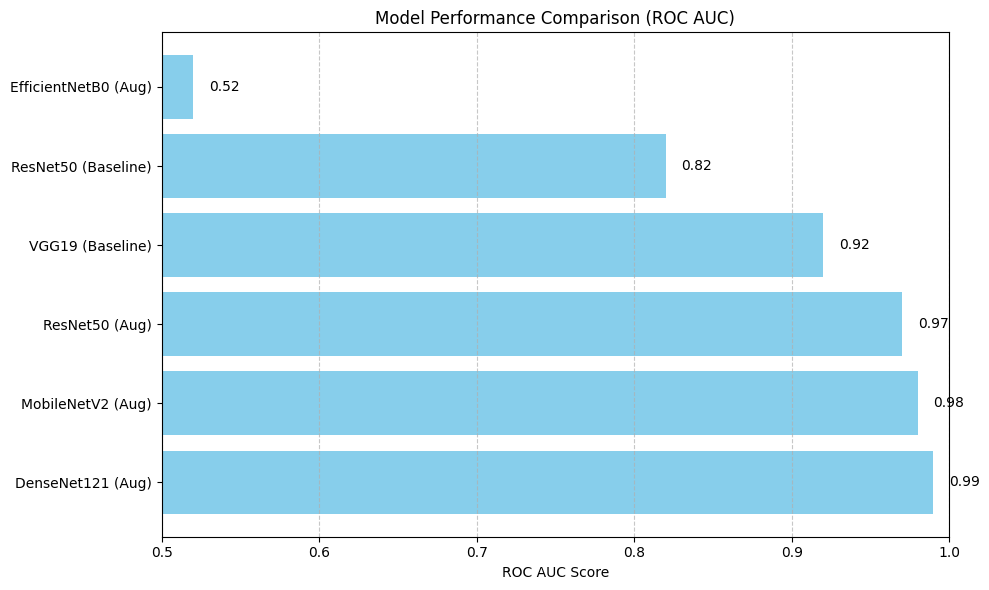

In [14]:
model_names = [
    "DenseNet121 (Aug)", "MobileNetV2 (Aug)", "ResNet50 (Aug)",
    "VGG19 (Baseline)", "ResNet50 (Baseline)", "EfficientNetB0 (Aug)"
]
auc_scores = [0.99, 0.98, 0.97, 0.92, 0.82, 0.52]

plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, auc_scores, color='skyblue')
plt.xlabel('ROC AUC Score')
plt.title('Model Performance Comparison (ROC AUC)')
plt.xlim(0.5, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center')

plt.tight_layout()
plt.savefig("model_auc_comparison.png", dpi=300)
plt.show()